In [508]:
# The IMDB data is large so I couldn't commit it to GitHub. You can download imdb_basics.tsv and imdb_ratings.tsv from the following website
# https://datasets.imdbws.com/

# Importing some functions to use in the implementation of the ML method
import numpy as np #import numpy to work with arrays
import pandas as pd #import pandas to manipulate the dataset
from matplotlib import pyplot as plt #import the module matplotlib.pyplot to do visulization
from sklearn.linear_model import HuberRegressor, Lasso, Ridge, LinearRegression
from sklearn.metrics import mean_squared_error    # function to calculate mean squared error 
from sklearn.model_selection import train_test_split # for splitting the set into train,validation and test sets

# Bunch of data preprocessing here
ratings = pd.read_csv('ratingsvol3.csv') # read in the personal ratings
ratings['Movie'] = ratings['Movie'].str.lower() # make all strings lowercase

val_ratings = pd.read_csv('ratings_validation.csv') # read in the personal ratings for validation set
val_ratings['Movie'] = val_ratings['Movie'].str.lower()

imdb_data = pd.read_csv('imdb_basics.tsv', sep = '\t', low_memory = False) # read in tsv
imdb_ratings = pd.read_csv('imdb_ratings.tsv', sep = '\t')
imdb_data = imdb_data.merge(imdb_ratings, on = 'tconst') # merge with ratings
imdb_data['Movie'] = imdb_data['Movie'].str.lower()

imdb_data = imdb_data.loc[(imdb_data['titleType'] == 'movie')] # pick only movies, no tv-shows or shorts for example
imdb_data = imdb_data.loc[(imdb_data['numVotes'] > 1000)] # filter out very obscure movies with similiar names
imdb_data['genres'] = imdb_data['genres'].str.split(',').apply(lambda x: x[0]) # pick only the first genre out of the three in the dataset
imdb_data.genres = pd.Categorical(imdb_data.genres) # make genres into integers instead of strings so that they can be used in the ML model
imdb_data['genreInt'] = imdb_data.genres.cat.codes # add a column with the genres as integers

In [509]:
ratings['Release_year'] = ratings['Release_year'].apply(lambda x: float(x)) # make release year into floats to be compatible with the imdb dataset
imdb_data['Release_year'] = pd.to_numeric(imdb_data['Release_year'], errors = 'coerce') # make make into floats as well, they are strings for some reason

newDf = imdb_data.merge(ratings, how = 'inner', on = ['Movie']) # combine ratings and imdb data using the name of the movie
newDf = newDf.loc[newDf.Release_year_x == newDf.Release_year_y] # filter out movies with the wrong release year (there are three movies named the little mermaid for example)

newDf2 = imdb_data.merge(val_ratings, how = 'inner', on = ['Movie']) # preprocess my second dataset of movies
newDf2 = newDf2.loc[newDf2.Release_year_x == newDf2.Release_year_y]

newDf = newDf.drop(['genres','tconst', 'titleType', 'originalTitle', 'isAdult', 'endYear', 'numVotes', 'Release_year_y', 'Onniscore', 'Eeroscore', 'Mikkoscore', 'Samppascore'], axis = 1)
newDf2 = newDf2.drop(['genres','tconst', 'titleType', 'originalTitle', 'isAdult', 'endYear', 'numVotes', 'Release_year_y'], axis = 1) # drop irrelevant data
fullDf = pd.concat([(newDf),(newDf2)], ignore_index=1) # combine both of my datasets of ratings into one large one for train, test
fullDf

,Movie,Release_year_x,runtimeMinutes,averageRating,genreInt,Gussescore
0,beauty and the beast,1991.0,84,8.1,3,7.75
1,hercules,1997.0,93,7.3,2,8.00
2,the cat from outer space,1978.0,104,6.0,5,3.00
3,alien,1979.0,117,8.5,13,9.00
4,life of brian,1979.0,94,8.1,5,6.00
...,...,...,...,...,...,...
118,free guy,2021.0,115,7.2,0,6.50
119,x-men: dark phoenix,2019.0,113,5.7,0,1.00
120,bad times at the el royale,2018.0,141,7.1,6,6.50
121,knives out,2019.0,130,7.9,5,7.50


In [525]:
# Train test split
X_train, X_val, y_train, y_val = train_test_split(fullDf.to_numpy().reshape(-1, 6), fullDf['Gussescore'], test_size=0.6, random_state = 50) # Split into 70% training set and 30% test and validation
X_val_true, X_test, y_val_true, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state = 61) # Split validation set into 50% validation and 50% testing sets

In [526]:
# Standard huber regression using SciKit
X_real_train = np.delete(X_train, [0,5], axis = 1)
X_real_val = np.delete(X_val_true, [0,5], axis = 1)

huber = HuberRegressor(max_iter = 200,  fit_intercept=False)
clf1 = huber.fit(X_real_train, y_train)
y_pred = pd.DataFrame(clf1.predict(X_real_train))
y_pred_val = pd.DataFrame(clf1.predict(X_real_val))

predDf = pd.concat([pd.DataFrame(X_train),(y_pred)], axis = 1)
validDf = pd.concat([pd.DataFrame(X_val_true),(y_pred_val)], axis = 1)

# Let's calculate the mean squared error for the training set and the validation set
print(f"Training error: {mean_squared_error(y_train,y_pred)}\nValidation error: {mean_squared_error(y_val_true,y_pred_val)}")

validDf

Training error: 1.6440957545470014
Validation error: 2.989237232464966


,0,1,2,3,4,5,0
0,kingsman: the secret service,2014.0,129,7.7,0,8.5,7.422640
1,g-force,2009.0,88,5.1,0,1.0,1.812401
2,tomb raider,2018.0,119,6.3,0,4.0,4.421808
3,hercules,1997.0,93,7.3,2,8.0,6.490593
4,xxx: state of the union,2005.0,101,4.4,0,1.5,0.415599
5,hitman,2007.0,100,6.3,0,2.0,4.392414
6,bohemian rhapsody,2018.0,134,8.0,4,6.0,8.018177
7,kung fu panda,2008.0,92,7.6,0,7.25,7.084231
8,race to witch mountain,2009.0,98,5.7,0,0.5,3.114667
9,the hunger games,2012.0,142,7.2,0,5.0,6.436638


In [527]:
# Ridge regression using SciKit as second model
lasso_model = Lasso(fit_intercept = False)
clf2 = lasso_model.fit(X_real_train, y_train)
y_pred_lasso = pd.DataFrame(clf2.predict(X_real_train))
y_pred_val_lasso = pd.DataFrame(clf2.predict(X_real_val))

predDf_lasso = pd.concat([pd.DataFrame(X_train),(y_pred_lasso)], axis = 1)
validDf_lasso = pd.concat([pd.DataFrame(X_val_true),(y_pred_val_lasso)], axis = 1)

print(f"Training error: {mean_squared_error(y_train,y_pred_lasso)}\nValidation error: {mean_squared_error(y_val_true,y_pred_val_lasso)}")

validDf_lasso

Training error: 2.805222704471474
Validation error: 5.218428438366832


,0,1,2,3,4,5,0
0,kingsman: the secret service,2014.0,129,7.7,0,8.5,7.132183
1,g-force,2009.0,88,5.1,0,1.0,4.067148
2,tomb raider,2018.0,119,6.3,0,4.0,5.713910
3,hercules,1997.0,93,7.3,2,8.0,6.089690
4,xxx: state of the union,2005.0,101,4.4,0,1.5,3.720729
5,hitman,2007.0,100,6.3,0,2.0,5.349205
6,bohemian rhapsody,2018.0,134,8.0,4,6.0,7.487585
7,kung fu panda,2008.0,92,7.6,0,7.25,6.318946
8,race to witch mountain,2009.0,98,5.7,0,0.5,4.786335
9,the hunger games,2012.0,142,7.2,0,5.0,6.957392


In [528]:
# Fit both models into test sets to compare
X_real_test = np.delete(X_test, [0,5], axis = 1)

y_pred_test = pd.DataFrame(clf1.predict(X_real_test)) # One for huber
y_pred_test_lasso = pd.DataFrame(clf2.predict(X_real_test)) # Second for ridge

Huber test error: 2.458625523333052
Lasso test error: 3.9999681989131575


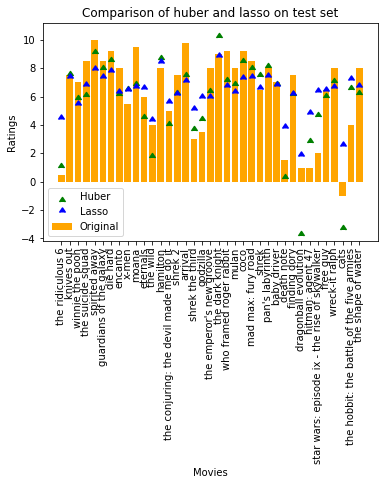

In [529]:
# Test set to see which model is better
fg, ax = plt.subplots() # Create figure for plot
ax.bar(X_test[:, 0], y_test, color = 'orange') # Original as bar graph
ax.scatter(X_test[:, 0], y_pred_test, color = 'g', marker = 6) # Predicted with huber
ax.scatter(X_test[:, 0], y_pred_test_lasso, color = 'b', marker = 10) # Predicted with ridge

plt.legend(['Huber','Lasso','Original'])

plt.title('Comparison of huber and lasso on test set')
plt.xlabel('Movies')
plt.ylabel('Ratings')
ax.tick_params(axis = 'x', rotation = 90)
print(f"Huber test error: {mean_squared_error(y_test,y_pred_test)}\nLasso test error: {mean_squared_error(y_test,y_pred_test_lasso)}")
